In [1]:
import joblib
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Load all models
models = {
    'Logistic Regression': joblib.load('models/model_logistic_regression.joblib'),
    'Random Forest': joblib.load('models/model_random_forest.joblib'),
    'Gradient Boosting': joblib.load('models/model_gradient_boosting.joblib'),
    'XGBoost': joblib.load('models/model_xgboost.joblib'),
    'LightGBM': joblib.load('models/model_lightgbm.joblib'),
    'Naive Bayes': joblib.load('models/model_naive_bayes.joblib')
}

vectorizer = joblib.load('models/vectorizer.joblib')

In [2]:
# Load comparison results
df_comparison = pd.read_csv('docs/model_comparison.csv')

# Styled table
df_comparison.style.background_gradient(cmap='RdYlGn', subset=['Accuracy', 'Precision', 'Recall', 'F1-Score']) \
                   .background_gradient(cmap='RdYlGn_r', subset=['Training Time (s)']) \
                   .format({'Accuracy': '{:.4f}', 'Precision': '{:.4f}', 
                           'Recall': '{:.4f}', 'F1-Score': '{:.4f}', 
                           'Training Time (s)': '{:.2f}s'})

,Model,Accuracy,Precision,Recall,F1-Score,Training Time (s)
0,Random Forest,0.9792,0.9944,0.9639,0.9789,1.52s
1,Logistic Regression,0.9790,0.9929,0.9649,0.9787,2.92s
2,LightGBM,0.9785,0.9908,0.9659,0.9782,4.10s
3,XGBoost,0.9770,0.9872,0.9666,0.9768,8.99s
4,Gradient Boosting,0.9766,0.9859,0.9670,0.9764,110.02s
5,Naive Bayes,0.9103,0.9322,0.8849,0.9079,0.01s


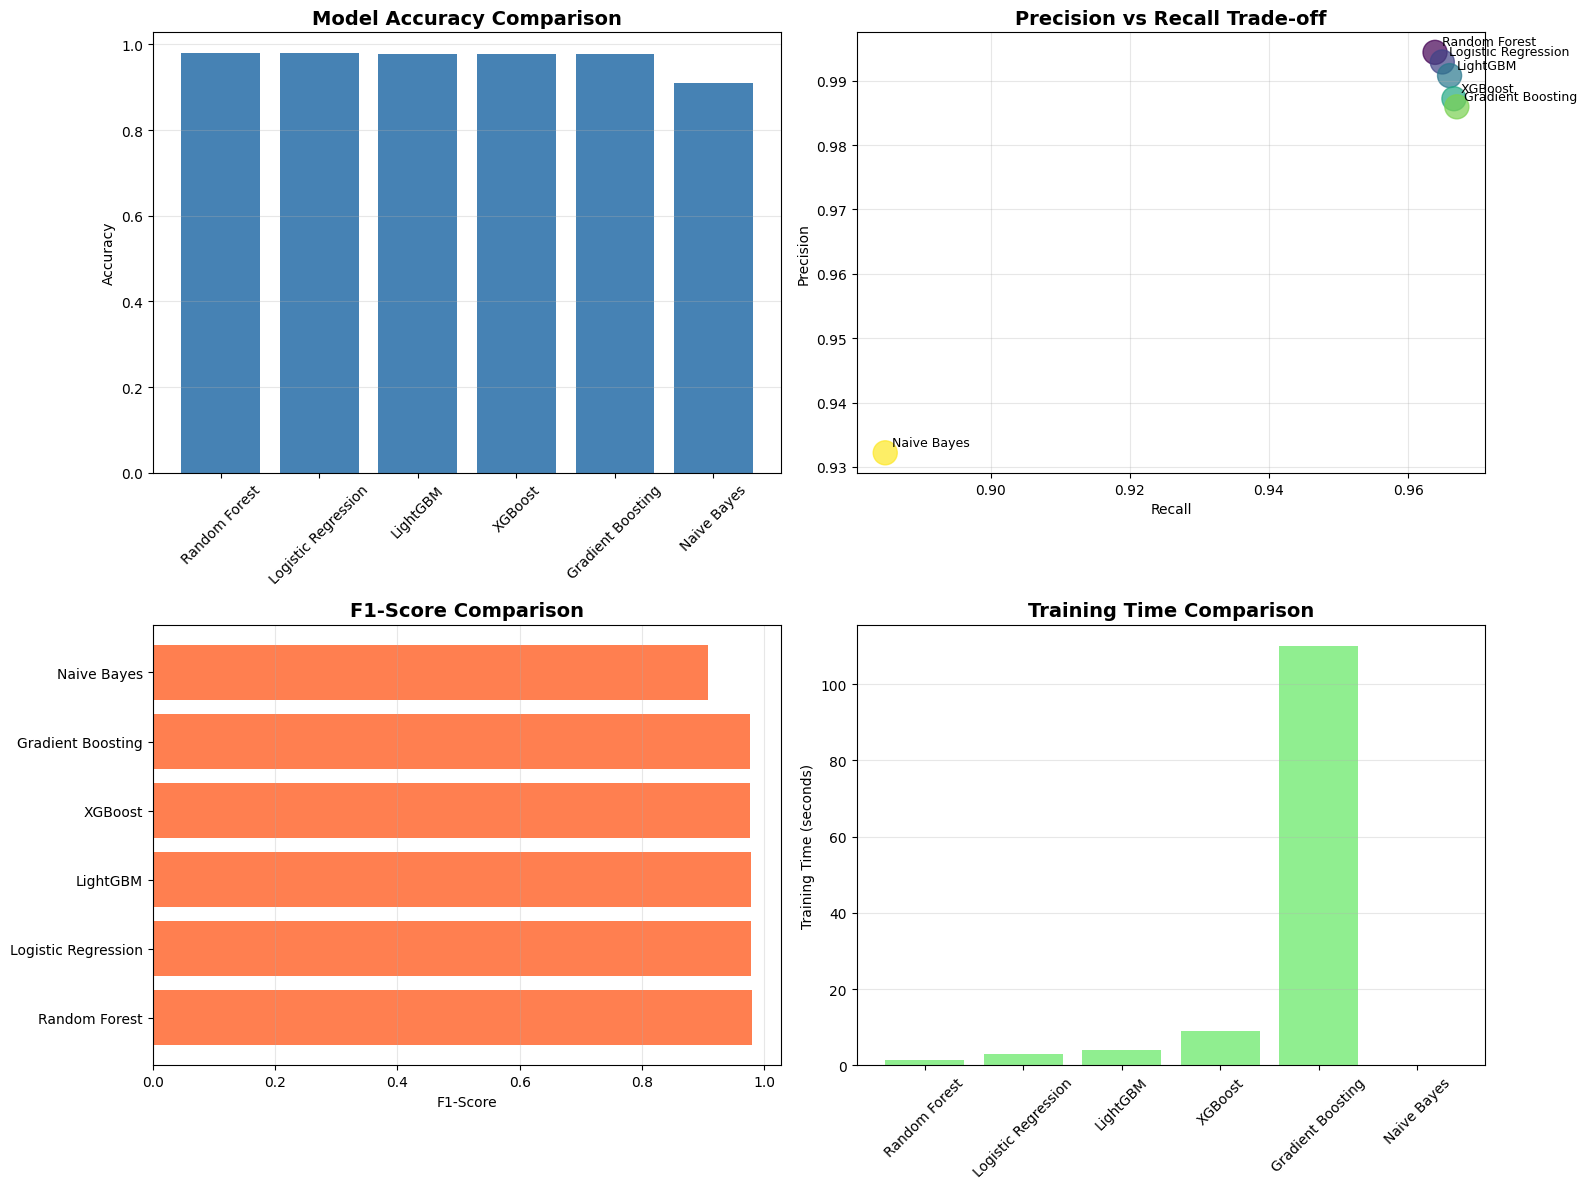

In [3]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Accuracy comparison
axes[0, 0].bar(df_comparison['Model'], df_comparison['Accuracy'], color='steelblue')
axes[0, 0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Precision vs Recall
axes[0, 1].scatter(df_comparison['Recall'], df_comparison['Precision'], 
                   s=300, c=range(len(df_comparison)), cmap='viridis', alpha=0.7)
for idx, row in df_comparison.iterrows():
    axes[0, 1].annotate(row['Model'], (row['Recall'], row['Precision']),
                       xytext=(5, 5), textcoords='offset points', fontsize=9)
axes[0, 1].set_xlabel('Recall')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_title('Precision vs Recall Trade-off', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. F1-Score comparison
axes[1, 0].barh(df_comparison['Model'], df_comparison['F1-Score'], color='coral')
axes[1, 0].set_xlabel('F1-Score')
axes[1, 0].set_title('F1-Score Comparison', fontsize=14, fontweight='bold')
axes[1, 0].grid(axis='x', alpha=0.3)

# 4. Training time comparison
axes[1, 1].bar(df_comparison['Model'], df_comparison['Training Time (s)'], color='lightgreen')
axes[1, 1].set_ylabel('Training Time (seconds)')
axes[1, 1].set_title('Training Time Comparison', fontsize=14, fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('docs/comprehensive_model_comparison.png', dpi=300)

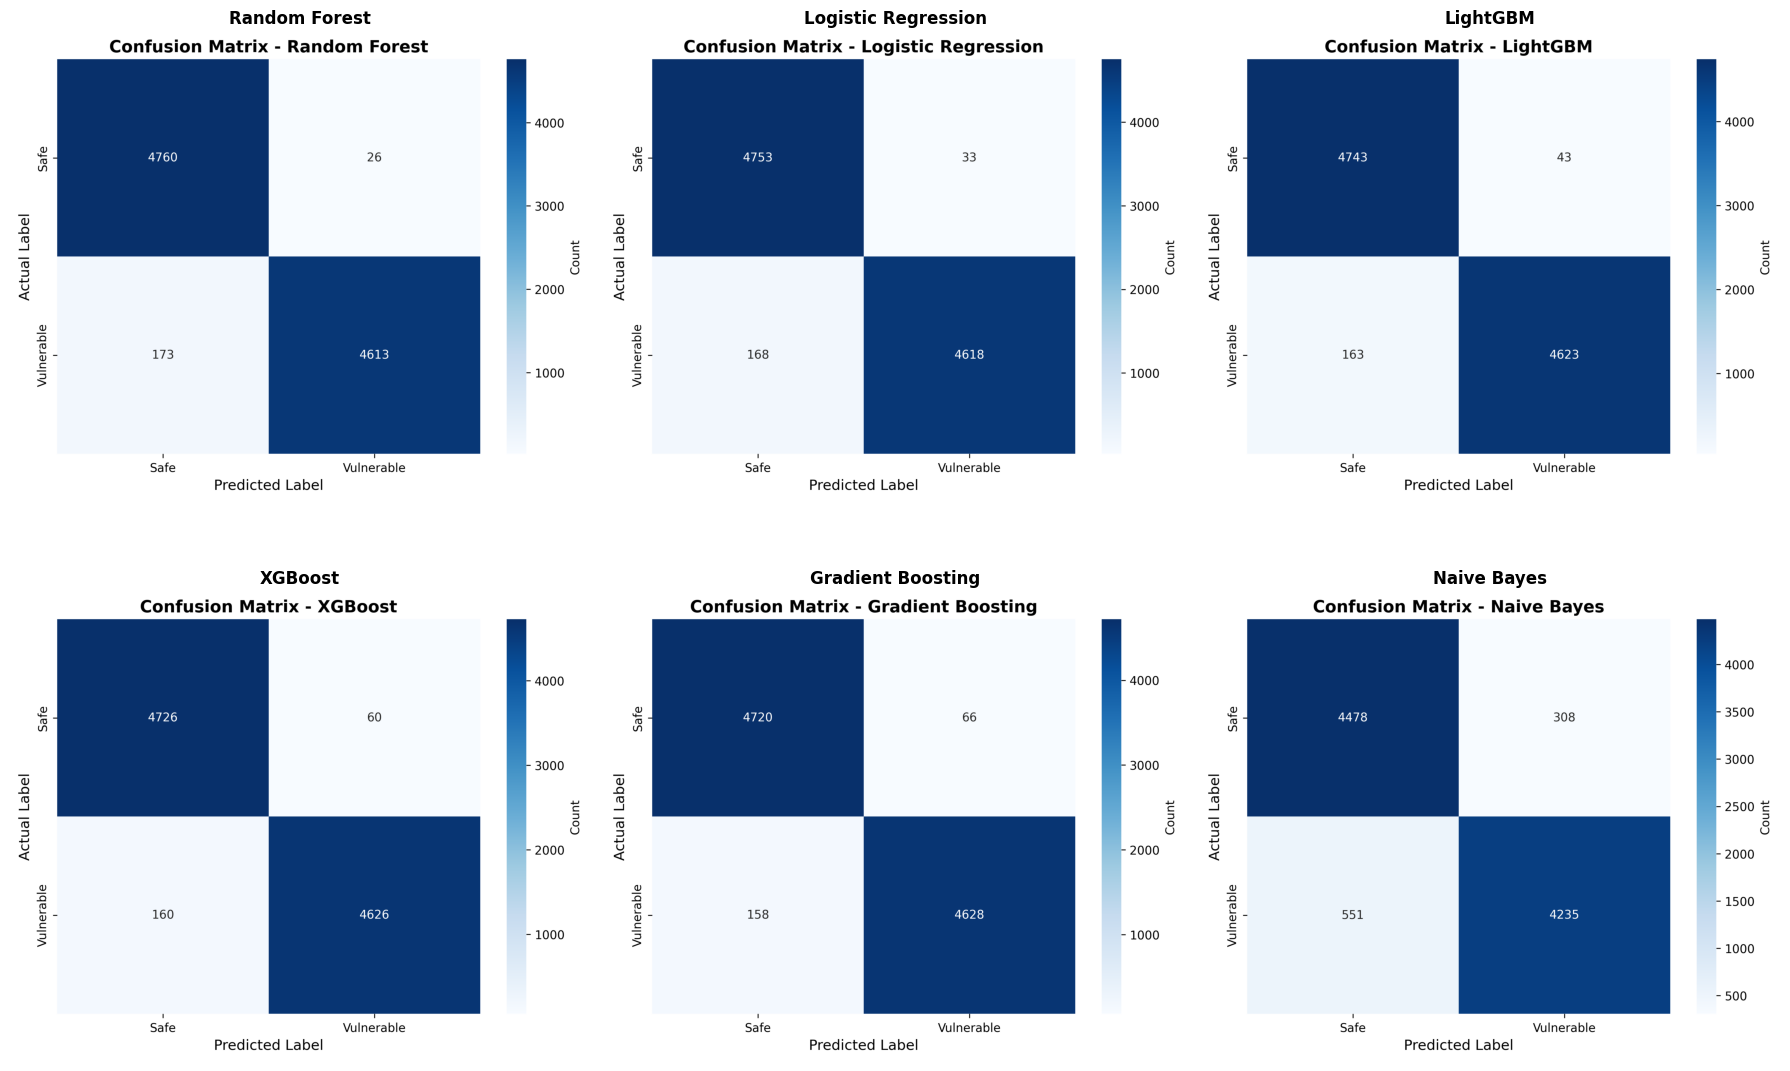

In [4]:
import os
from PIL import Image

# Display all confusion matrices in a grid
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, model_name in enumerate(df_comparison['Model']):
    filename = model_name.lower().replace(' ', '_')
    img_path = f'docs/confusion_matrix_{filename}.png'
    
    if os.path.exists(img_path):
        img = Image.open(img_path)
        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(model_name, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('docs/all_confusion_matrices.png', dpi=300)

C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


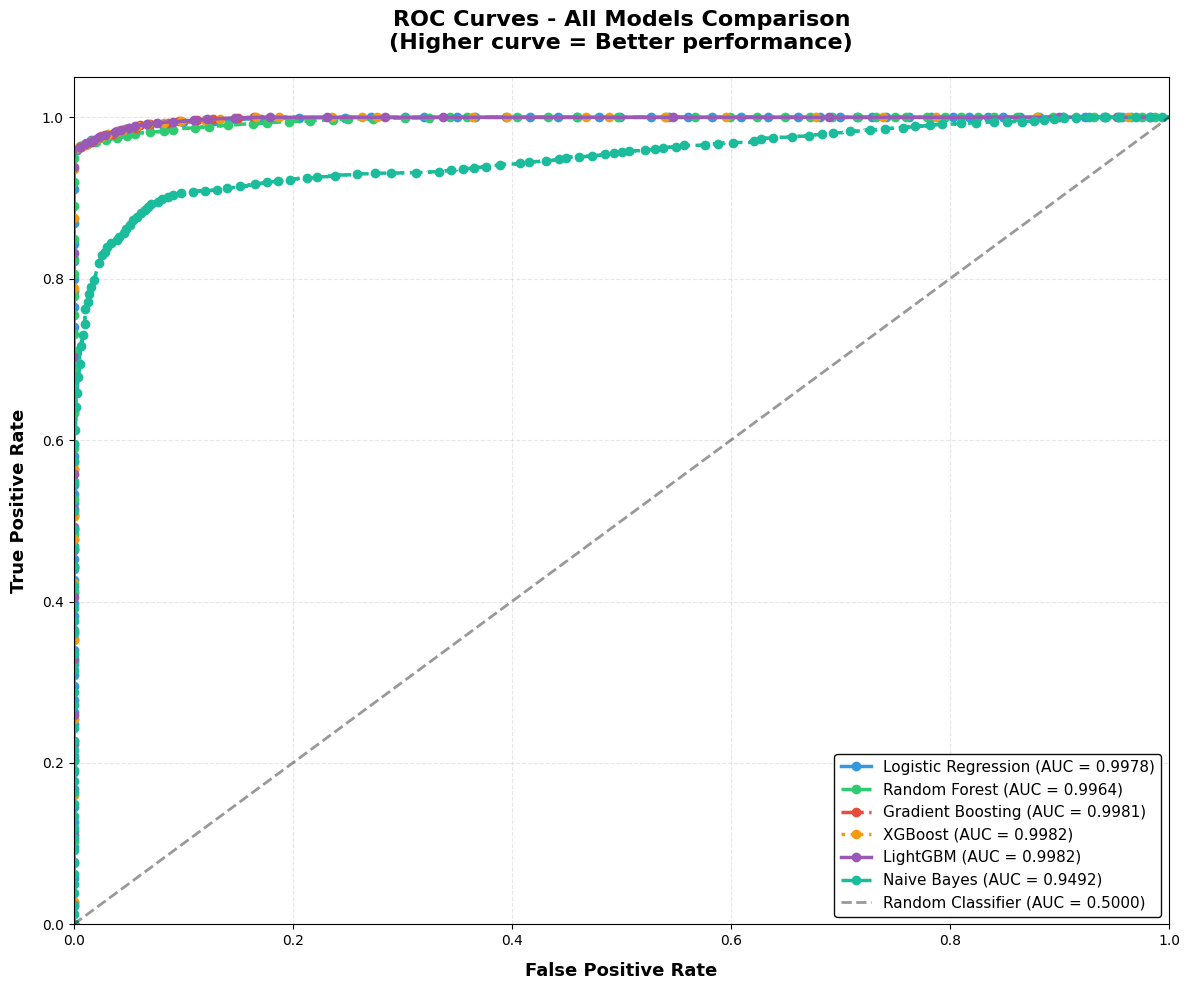

✓ ROC curves saved to docs/roc_curves.png


In [6]:
# Cell 5: ROC Curves
import numpy as np
from sklearn.metrics import roc_curve, auc

# Load test data
df = pd.read_csv('data/balanced_merged_dataset.csv')
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df['code'], df['is_vulnerable'], test_size=0.2, random_state=42, stratify=df['is_vulnerable']
)

X_test_vec = vectorizer.transform(X_test)

# Create ROC curves
plt.figure(figsize=(12, 10))

colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12', '#9b59b6', '#1abc9c']
line_styles = ['-', '--', '-.', ':', '-', '--']

for idx, (model_name, model) in enumerate(models.items()):
    # Get probability predictions
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test_vec)[:, 1]
    else:
        # For models without predict_proba (rare case)
        y_pred_proba = model.decision_function(X_test_vec)
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # Plot
    plt.plot(fpr, tpr, color=colors[idx], linestyle=line_styles[idx],
             linewidth=2.5, label=f'{model_name} (AUC = {roc_auc:.4f})',
             marker='o', markevery=20, markersize=6)

# Plot diagonal (random classifier)
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.4, 
         label='Random Classifier (AUC = 0.5000)')

# Styling
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=13, fontweight='bold', labelpad=10)
plt.ylabel('True Positive Rate', fontsize=13, fontweight='bold', labelpad=10)
plt.title('ROC Curves - All Models Comparison\n(Higher curve = Better performance)', 
          fontsize=16, fontweight='bold', pad=20)
plt.legend(loc='lower right', fontsize=11, framealpha=0.95, edgecolor='black')
plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
plt.tight_layout()

# Save
plt.savefig('docs/roc_curves.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ ROC curves saved to docs/roc_curves.png")

C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


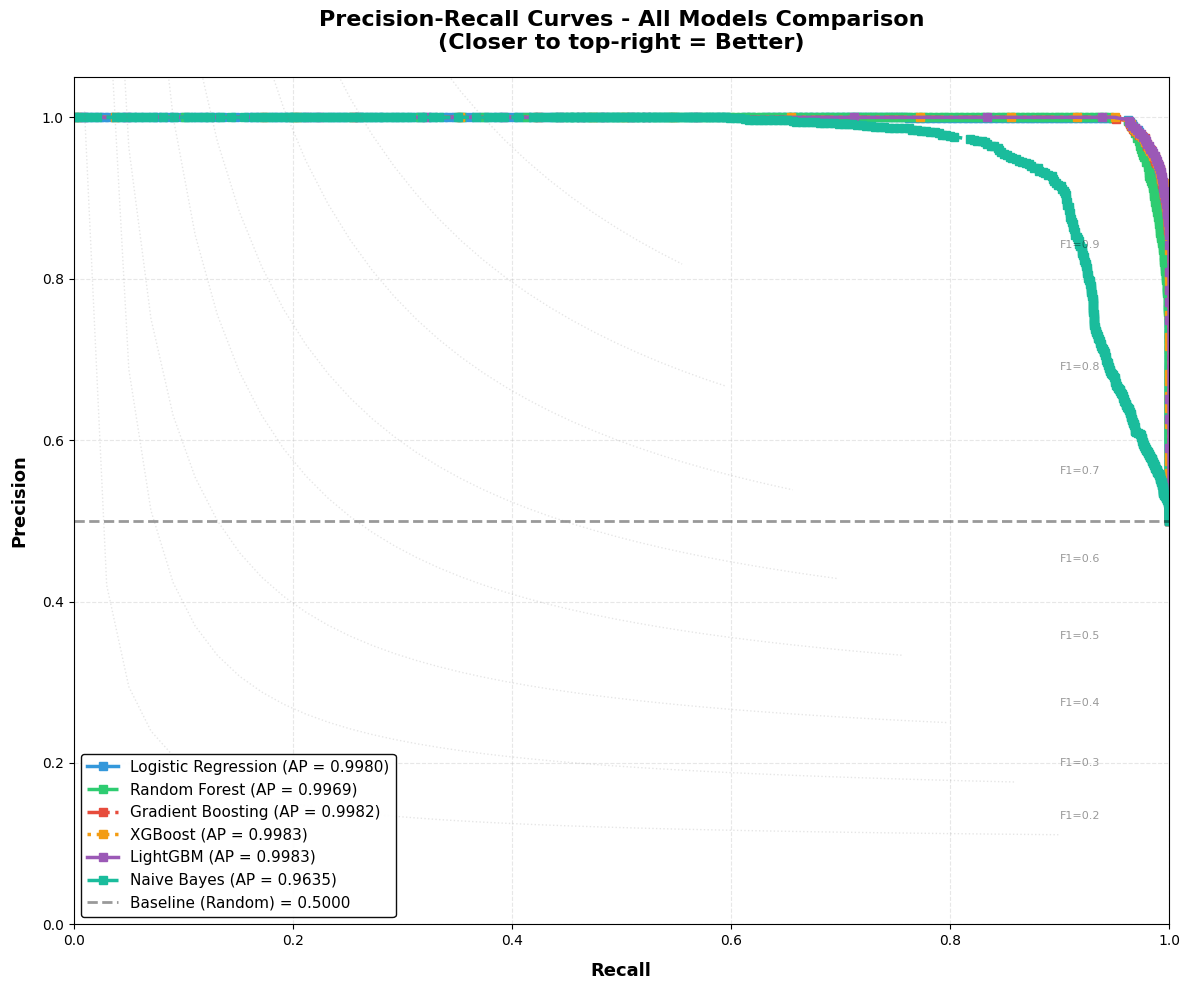

✓ Precision-Recall curves saved to docs/precision_recall_curves.png


In [7]:
# Cell 6: Precision-Recall Curves
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(12, 10))

for idx, (model_name, model) in enumerate(models.items()):
    # Get probability predictions
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test_vec)[:, 1]
    else:
        y_pred_proba = model.decision_function(X_test_vec)
    
    # Calculate Precision-Recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)
    
    # Plot
    plt.plot(recall, precision, color=colors[idx], linestyle=line_styles[idx],
             linewidth=2.5, label=f'{model_name} (AP = {avg_precision:.4f})',
             marker='s', markevery=20, markersize=6)

# Add baseline (random classifier for this dataset)
baseline = sum(y_test) / len(y_test)
plt.axhline(y=baseline, color='k', linestyle='--', linewidth=2, alpha=0.4,
            label=f'Baseline (Random) = {baseline:.4f}')

# Add F1-Score contours (optional - shows F1 isolines)
f_scores = np.linspace(0.2, 0.9, num=8)
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    y = y[y >= 0]
    plt.plot(x[:len(y)], y, color='gray', alpha=0.2, linestyle=':', linewidth=1)
    plt.annotate(f'F1={f_score:.1f}', xy=(0.9, y[min(45, len(y)-1)] + 0.02), 
                 fontsize=8, alpha=0.4)

# Styling
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=13, fontweight='bold', labelpad=10)
plt.ylabel('Precision', fontsize=13, fontweight='bold', labelpad=10)
plt.title('Precision-Recall Curves - All Models Comparison\n(Closer to top-right = Better)', 
          fontsize=16, fontweight='bold', pad=20)
plt.legend(loc='lower left', fontsize=11, framealpha=0.95, edgecolor='black')
plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
plt.tight_layout()

# Save
plt.savefig('docs/precision_recall_curves.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Precision-Recall curves saved to docs/precision_recall_curves.png")

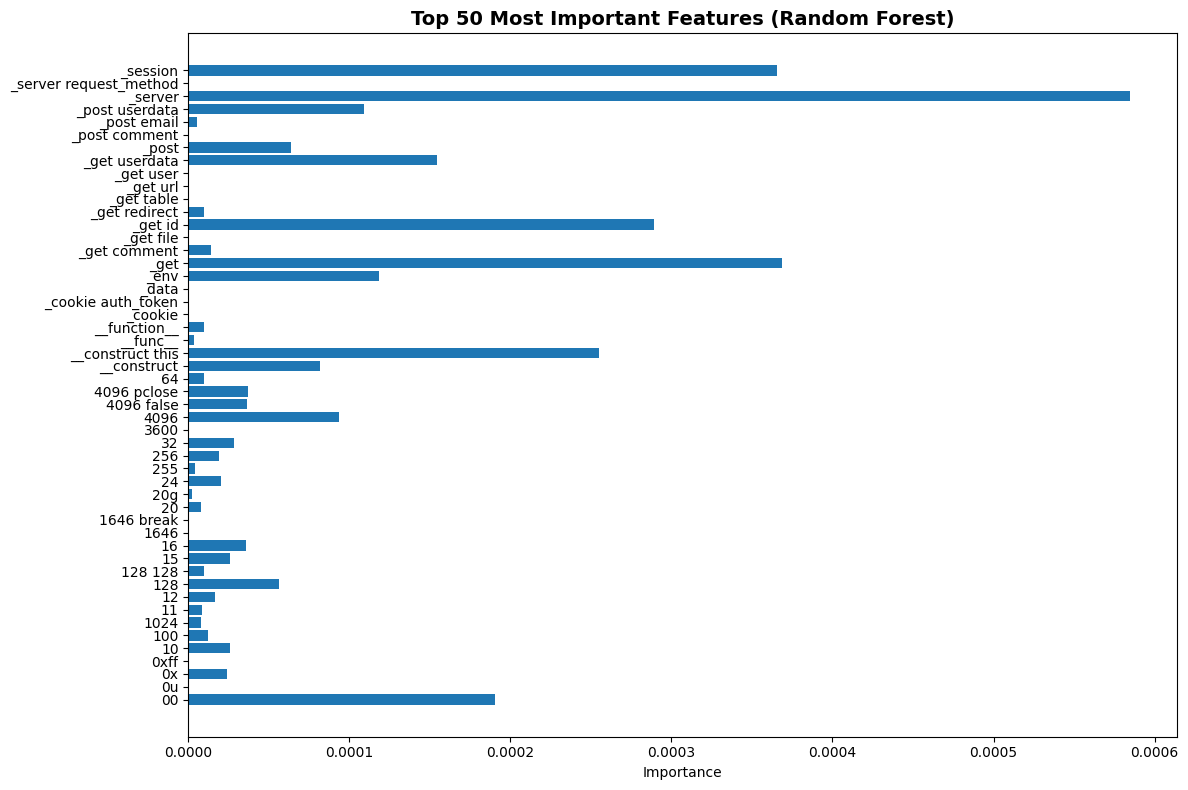

In [ ]:
# Random Forest feature importance
rf_model = models['Random Forest']
feature_names = vectorizer.get_feature_names_out()[:50]  # Top 50 features
importances = rf_model.feature_importances_[:50]

plt.figure(figsize=(12, 8))
plt.barh(range(len(importances)), importances)
plt.yticks(range(len(importances)), feature_names)
plt.xlabel('Importance')
plt.title('Top 50 Most Important Features (Random Forest)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('docs/feature_importance.png', dpi=300)